<center><h1>Sentiment Analysis</h1></center>
<center><h3>using HuggingFace & Pytorch</h3></center>

### Import packages

In [1]:
import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AdamW

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [2]:
from __future__ import print_function

from typing import List, Union, Mapping

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
torch.cuda.is_available()

True

Set random state & seed

In [4]:
SEED = 311200

np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Constants

In [5]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

TEST_SIZE = 0.1
MAX_SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10

In [6]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [7]:
label_encoder = LabelEncoder()

### Dataset

In [8]:
def preprocess(dataframe):
    dataframe = dataframe[["OriginalTweet", "Sentiment"]]
    return dataframe.rename(columns = {"OriginalTweet": "corpus", "Sentiment": "labels"})

In [9]:
train_dataframe, val_dataframe = train_test_split(preprocess(pd.read_csv("Corona_NLP_train.csv", encoding='latin-1')), test_size=TEST_SIZE)
test_dataframe = preprocess(pd.read_csv("Corona_NLP_test.csv", encoding='latin-1'))

train_dataframe = train_dataframe.iloc[:1600*5]

In [10]:
train_dataframe["labels"]   = label_encoder.fit_transform(train_dataframe["labels"])
val_dataframe["labels"]     = label_encoder.fit_transform(val_dataframe["labels"])
test_dataframe["labels"]    = label_encoder.fit_transform(test_dataframe["labels"])

train_dataframe.reset_index(drop=True, inplace=True)
val_dataframe.reset_index(drop=True, inplace=True)
test_dataframe.reset_index(drop=True, inplace=True)

In [11]:
class TextClassificationDataset(Dataset):

    def __init__(self, corpus: List[str], labels: List[str], max_seq_length: int, dataset_name: str, tokenizer = None, tokenizer_model: str = None) -> None:
        self.corpus = corpus
        self.labels = labels

        self.max_seq_length = max_seq_length

        self.dataset_name = dataset_name
        self.tokenizer_model = tokenizer_model

        if tokenizer == None:
            try:
                self.tokenizer = BertTokenizer.from_pretrained(self.tokenizer_model)
            except:
                self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_model)
        else:
            self.tokenizer = tokenizer
        
        self.sep_token = self.tokenizer.vocab["[SEP]"]
        self.cls_token = self.tokenizer.vocab["[CLS]"]
        self.pad_token = self.tokenizer.vocab["[PAD]"]

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, index) -> Mapping[str, Union[str,torch.Tensor]]:
        text = self.corpus[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            max_length = self.max_seq_length,
            add_special_tokens = True,
            return_token_type_ids = False,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return {
            'text': text, 
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
class TextClassificationLoader:

    def get_loader(name, dataframe, max_seq_length, batch_size):
        dataset = TextClassificationDataset(
            corpus = dataframe['corpus'],
            labels = dataframe['labels'],
            max_seq_length = max_seq_length,
            tokenizer = tokenizer,
            dataset_name = name
        )

        return DataLoader(
            dataset, batch_size=batch_size, shuffle=True #, num_workers = 4
        )

In [13]:
# train_ds = TextClassificationDataset(
#     corpus = train_dataframe['corpus'],
#     labels = train_dataframe['labels'],
#     max_seq_length = MAX_SEQ_LEN,
#     tokenizer = tokenizer,
#     dataset_name = "train"
# )
# train_load = DataLoader(train_ds, batch_size=64, shuffle=True)
# data = next(iter(train_load))
# print(data['input_ids'].shape)
# print(data['attention_mask'].shape)
# print(data['labels'].shape)


In [14]:
train_dataset   = TextClassificationLoader.get_loader("train", train_dataframe, MAX_SEQ_LEN, BATCH_SIZE)
val_dataset     = TextClassificationLoader.get_loader("val", val_dataframe, MAX_SEQ_LEN, BATCH_SIZE)
test_dataset    = TextClassificationLoader.get_loader("test", test_dataframe, MAX_SEQ_LEN, BATCH_SIZE)

In [15]:
LABELS = list(np.unique(train_dataframe["labels"]))
NUM_LABELS = len(LABELS)
LABELS, NUM_LABELS

([0, 1, 2, 3, 4], 5)

In [16]:
def testing_dataset():
    data = next(iter(test_dataset))

    print(data.keys())
    print(data['input_ids'].shape)
    print(data['attention_mask'].shape)
    print(data['labels'].shape)

def testing_sample():
    sample = "Good morning, how are you my dear? I am really grateful for today's meeting."

    tokens = tokenizer.tokenize(sample)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    print(f' Sentence: {sample}')
    print(f'   Tokens: {tokens}')
    print(f'Token IDs: {token_ids}')

testing_dataset()
testing_sample()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])
 Sentence: Good morning, how are you my dear? I am really grateful for today's meeting.
   Tokens: ['Good', 'morning', ',', 'how', 'are', 'you', 'my', 'dear', '?', 'I', 'am', 'really', 'grateful', 'for', 'today', "'", 's', 'meeting', '.']
Token IDs: [2750, 2106, 117, 1293, 1132, 1128, 1139, 7059, 136, 146, 1821, 1541, 9473, 1111, 2052, 112, 188, 2309, 119]


C:\Users\Antoine\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Model

In [17]:
class BertClassification(nn.Module):

    def __init__(self, pretrained_model_name: str, num_labels: int = str) -> None:
        super(BertClassification, self).__init__()

        try:
            self.model = BertModel.from_pretrained(pretrained_model_name)
        except:
            config = AutoConfig.from_pretrained(pretrained_model_name, num_labels = num_labels)
            self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)

        self.dropout = nn.Dropout(p = 0.3)
        self.final_layer = nn.Linear(self.model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, head_mask=None):
        output = self.model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            head_mask = head_mask
        )

        output = self.dropout(output[0].mean(axis=1))
        output = self.final_layer(output)

        return output

In [18]:
model = BertClassification(PRE_TRAINED_MODEL_NAME, NUM_LABELS)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training Loop

In [19]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataset) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [20]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, total_length):
    model = model.train()

    losses = []
    correct_predictions = 0

    index = 1

    for data in data_loader:

        input_ids       = data["input_ids"].to(device)
        attention_mask  = data["attention_mask"].to(device)
        labels          = data["labels"].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)

        _, preds = torch.max(outputs, dim = 1)
        
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        accuracy = round(float(correct_predictions.double() / (index*BATCH_SIZE)), 4)
        try: loss_value = losses[-1]
        except: loss_value = 0
        print(f" {index}/{int(len(train_dataframe)/BATCH_SIZE)} : accuracy {accuracy} \t loss {loss_value}", end="\r")

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        index += 1

    return correct_predictions.double() / total_length, np.mean(losses)


In [21]:
def eval_model(model, data_loader, loss_fn, device, total_length):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids       = data["input_ids"].to(device)
            attention_mask  = data["attention_mask"].to(device)
            labels          = data["labels"].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)

            _, preds = torch.max(outputs, dim = 1)

            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / total_length, np.mean(losses)

In [22]:
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': [],
}
best_accuracy = 0

length_train = len(train_dataframe)
length_val = len(val_dataframe)

EPOCHS = 5

for epoch in range(EPOCHS):
    print(f'Epoch n°{epoch+1}/{EPOCHS}')
    print('-' * 20)

    train_acc, train_loss = train_epoch(
        model, train_dataset, loss_fn, optimizer, device, scheduler, length_train
    )

    print(f' [Train] loss {train_loss} / acc {train_acc}')

    val_acc, val_loss = eval_model(
        model, val_dataset, loss_fn, device, length_val
    )

    print(f' [Val] loss {val_loss} / acc {val_acc}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch n°1/5
--------------------
 [Train] loss 1.0345918399095535 / acc 0.562250631717
 [Val] loss 0.7434204404437265 / acc 0.7118561710398444

Epoch n°2/5
--------------------
 [Train] loss 0.5549457947313785 / acc 0.7937500000000001
 [Val] loss 0.863855108849762 / acc 0.7028668610301263

Epoch n°3/5
--------------------
 [Train] loss 0.3204675003401935 / acc 0.8921250000000001
 [Val] loss 0.9021283412539913 / acc 0.7322643343051506

Epoch n°4/5
--------------------
 [Train] loss 0.19909360670950263 / acc 0.9417518563145
 [Val] loss 1.1870251112480381 / acc 0.7337220602526725

Epoch n°5/5
--------------------
 [Train] loss 0.13533153914660215 / acc 0.9622539700365
 [Val] loss 1.5387078069850744 / acc 0.7334791059280855



(0.0, 1.0)

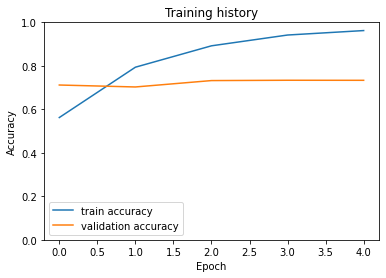

In [23]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

(0.0, 1.0)

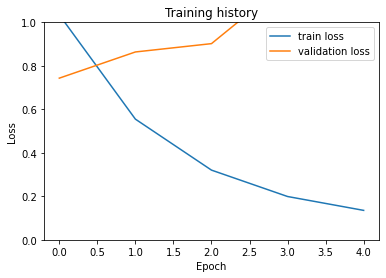

In [25]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])